# Develop an ML Gaussian Process Regression model to learn Hardness Property of High entropy alloys

The dataset for this tutorial is taken from the following publication:

Wen, Cheng, et al. "Machine learning assisted design of high entropy alloys with desired property." Acta Materialia 170 (2019): 109-117 (https://doi.org/10.1016/j.actamat.2019.03.010).

This tutorial is similar to the previous linear regression tutorial. Here, instead of a linear model we will create a non-linear ML model (GPR) for high entropy alloy property prediction. We will achieve the following things:
1. Load high entropy alloy dataset
2. Use scikit-learn library to build GPR model
3. Cross-validation for hyper-parameter optimization
4. Training final GPR model
5. Uncertainty quantification
6. Feature selection using recursive feature elimination
7. Understanding the meaning of different hyper-parameters

#### Library imports

In [135]:
import pandas as pd  # To play with data tables
import matplotlib.pyplot as plt  # To visualize data
import numpy as np
import time

In [136]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [137]:
from sklearn.model_selection import KFold

In [138]:
from sklearn.model_selection import GridSearchCV
import itertools

In [139]:
# First we will define function to make plots. This will make the code simpler.

def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.
    """

    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)

    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)

    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])

    if y_cv_train is not None:
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)

        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])

    plt.tight_layout()
    plt.show()

    return None

### 1. Load data table

In [140]:
!gdown 12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h

Downloading...
From: https://drive.google.com/uc?id=12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h
To: /content/alloy-confp-train-data_v2.csv
100% 7.33k/7.33k [00:00<00:00, 19.8MB/s]


In [141]:
data = pd.read_csv('alloy-confp-train-data_v2.csv')
data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000
1,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846
2,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222
3,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857
4,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818
...,...,...,...,...,...,...,...,...
115,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667
116,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059
117,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667
118,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667


### Notes about the data table

Above we see that data table has 5 types of columns:
1. smiles: These are string representation of polymers. We will use them to visualize polymers.
2. eib: We can ignore this for now.
3. bandgap_chain: This is the band gap values of polymers. Our target property (y).
4. bandgap_crystal: We can ignore this for now.
5. several columns starting with keyword "mfp_": These are molecular fingerprint columns that we will use for ML model. Our material fingeprints (X).

Notice we use small letter "y" and capital letter "X" to represent our target property and materials fingeprints respectively. Is there any particular reason for representing one with small and the other with capital alphabet?

#### Seperate X and y data

In [142]:
Xcols = data.columns[data.columns.str.contains("C.")]
Xcols

Index(['C.al', 'C.co', 'C.cr', 'C.cu', 'C.fe', 'C.ni'], dtype='object')

In [143]:
X = data[Xcols]
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000
1,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846
2,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222
3,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857
4,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818
...,...,...,...,...,...,...
115,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667
116,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059
117,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667
118,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667


In [144]:
y = data['HV']
y

0      139
1      295
2      545
3      701
4      207
      ... 
115    249
116    450
117    451
118    617
119    171
Name: HV, Length: 120, dtype: int64


---


### 2. Fit GPR model with five-fold cross-validation

In [145]:
noise_estimated = 30
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e2))
kernel.k1.constant_value_bounds = (10**-2, 10**7)

In [146]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_estimated**2, n_restarts_optimizer=9
)

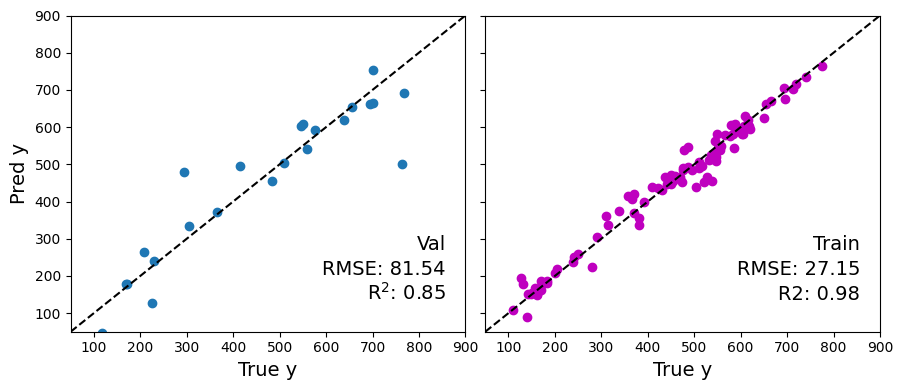

Kernel parameters: 306**2 * RBF(length_scale=0.184)
log marginal likelihood: -580.513
Root mean squared error: 81.54
Coefficient of determination: 0.85


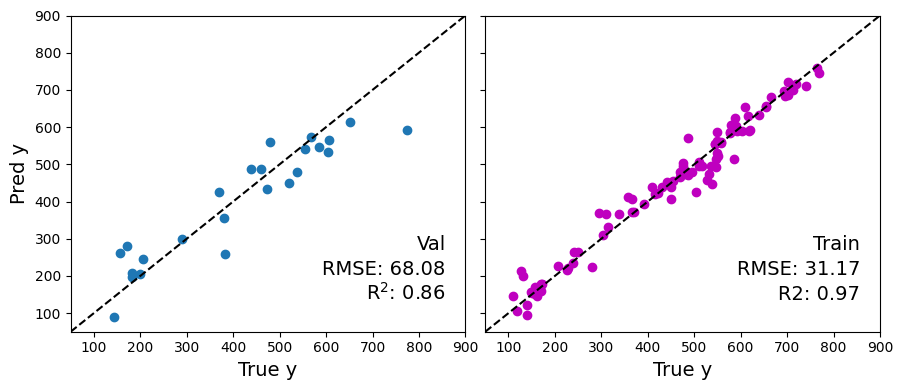

Kernel parameters: 327**2 * RBF(length_scale=0.223)
log marginal likelihood: -579.677
Root mean squared error: 68.08
Coefficient of determination: 0.86


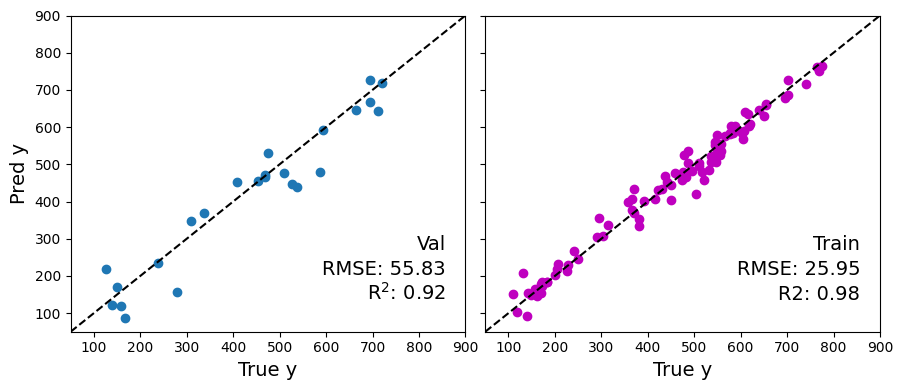

Kernel parameters: 321**2 * RBF(length_scale=0.202)
log marginal likelihood: -577.081
Root mean squared error: 55.83
Coefficient of determination: 0.92


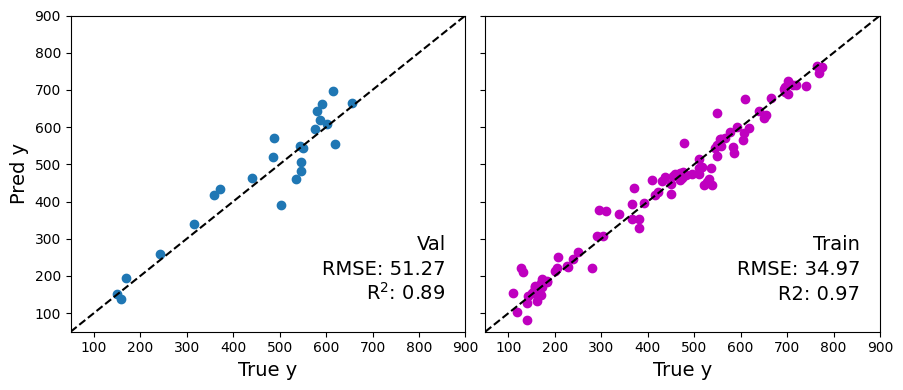

Kernel parameters: 332**2 * RBF(length_scale=0.255)
log marginal likelihood: -583.741
Root mean squared error: 51.27
Coefficient of determination: 0.89


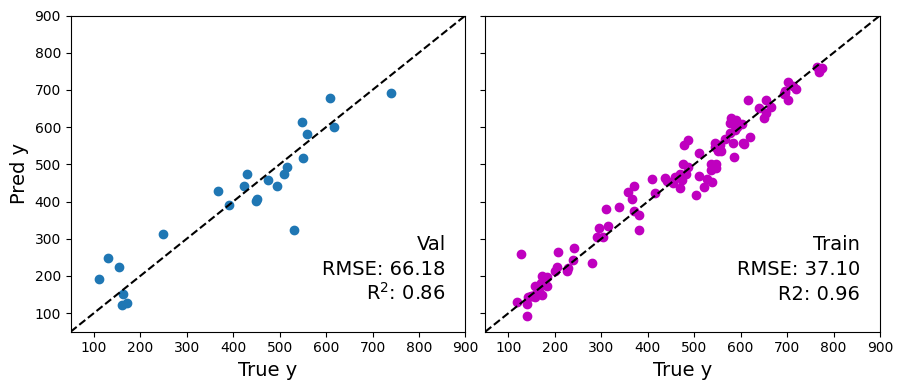

Kernel parameters: 329**2 * RBF(length_scale=0.299)
log marginal likelihood: -576.231
Root mean squared error: 66.18
Coefficient of determination: 0.86


In [147]:
kf = KFold(n_splits=5)

errors = []
kernels = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("log marginal likelihood: %.3f" %model.log_marginal_likelihood_value_)
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)
    kernels.append(model.kernel_)

In [148]:
errors_gpr_cv = pd.DataFrame(errors)
errors_gpr_cv

,kfold,rmse_train,r2_train,rmse_val,r2_val
0,1,27.152116,0.976949,81.542323,0.853598
1,2,31.169462,0.972324,68.082337,0.857943
2,3,25.949473,0.980072,55.828620,0.918961
3,4,34.973802,0.967088,51.267013,0.888531
4,5,37.097890,0.961151,66.176655,0.859012


In [149]:
errors_gpr_cv[['rmse_val','r2_val']].mean()

rmse_val    64.579390
r2_val       0.875609
dtype: float64

#### Comparing against Best Error from Polynomial Regression (from Previous notebook).
1. rmse_test: 77.69
2. r2_test: 0.81

### Question



1. Compare the GPR and linear regression model in terms of accuracy? Is such behavior always expected?

Running the similar code to compare the accuracy of both the models

In [150]:
from sklearn.linear_model import LinearRegression

In [151]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

errors_gpr = []
errors_lr = []

gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_estimated**2, n_restarts_optimizer=9
)

for idx, (train, val) in enumerate(kf.split(X)):
    X_train, X_val = X.values[train], X.values[val]
    y_train, y_val = y.values[train], y.values[val]

    model_gpr = gaussian_process.fit(X_train, y_train)
    y_pred_gpr = model_gpr.predict(X_val)

    rmse_gpr = np.sqrt(mean_squared_error(y_val, y_pred_gpr))
    r2_gpr = r2_score(y_val, y_pred_gpr)
    errors_gpr.append({'fold': idx+1, 'rmse': rmse_gpr, 'r2': r2_gpr})

    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_val)

    rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
    r2_lr = r2_score(y_val, y_pred_lr)
    errors_lr.append({'fold': idx+1, 'rmse': rmse_lr, 'r2': r2_lr})

errors_gpr_df = pd.DataFrame(errors_gpr)
errors_lr_df = pd.DataFrame(errors_lr)

average_rmse_gpr = errors_gpr_df['rmse'].mean()
average_r2_gpr = errors_gpr_df['r2'].mean()
average_rmse_lr = errors_lr_df['rmse'].mean()
average_r2_lr = errors_lr_df['r2'].mean()

print("Gaussian Process Regression:")
print("Average RMSE:", average_rmse_gpr)
print("Average R²:", average_r2_gpr)
print("\nLinear Regression:")
print("Average RMSE:", average_rmse_lr)
print("Average R²:", average_r2_lr)


Gaussian Process Regression:
Average RMSE: 70.01759349412261
Average R²: 0.8351274551334289

Linear Regression:
Average RMSE: 91.08942713624772
Average R²: 0.7254706562820669


* Higher RMSE value of Linear regression model suggests that the distance or the difference between the predicted value and the true value is high. In this case there is high possibility that the relationship is not linear which could cause this high error.
* While the $R^2$ measure the variance of the target variable predicted from the feature variable.So higher the value of $R^2$ means the model has a better fit. In this case it is observerd that the guassian process model has a better fit compared to linear regression model this is due to it is non-parametric and can identify complex patterns or we can say non-linear relationships between the target variables and the features.

2. What can we do to improve the performance of GPR model?

* We can improve the performance of the model by changing the kernal in the above example we are using the radial basis function (RBF) instead we could try others like exponential.

* By changing the noise that $\alpha$ parameter which is responsible for models uncertainity estimates.

#### Using the median kernel parameters obtained from different k-folds

In [152]:
kernels

[306**2 * RBF(length_scale=0.184),
 327**2 * RBF(length_scale=0.223),
 321**2 * RBF(length_scale=0.202),
 332**2 * RBF(length_scale=0.255),
 329**2 * RBF(length_scale=0.299)]

In [153]:
sigma_cs = []
sigma_ls = []

for k in kernels:
    sigma_cs.append(k.k1.constant_value)
    sigma_ls.append(k.k2.length_scale)
k_best = np.median(sigma_cs) * RBF(length_scale=np.median(sigma_ls), length_scale_bounds=(1e-4, 1e2))
k_best.k1.constant_value_bounds = (10**-2, 10**7)

In [154]:
np.median(sigma_cs), np.median(sigma_ls)

(106745.3469671848, 0.22312401209506114)

In [155]:
k_best

327**2 * RBF(length_scale=0.223)

***

### 3. Optimization of alpha param

In [156]:
alpha_values = np.array([26, 30, 31, 32, 33, 34, 35, 36, 39, 40, 42, 45])**2
hyper_params = {'alpha':alpha_values}

In [157]:
kernel = k_best.k1.constant_value * RBF(length_scale=k_best.k2.length_scale, length_scale_bounds=(1e-4, 1e2))
kernel.k1.constant_value_bounds = (10**-2, 10**7)

In [158]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)

In [159]:
clf2 = GridSearchCV(gaussian_process, hyper_params, cv=5,
                   scoring='neg_mean_squared_error', verbose=0)

In [160]:
clf2.fit(X,y)

GridSearchCV(cv=5,
             estimator=GaussianProcessRegressor(kernel=327**2 * RBF(length_scale=0.223),
                                                n_restarts_optimizer=3),
             param_grid={'alpha': array([ 676,  900,  961, 1024, 1089, 1156, 1225, 1296, 1521, 1600, 1764,
       2025])},
             scoring='neg_mean_squared_error')

In [161]:
rmse_list2 = np.sqrt(clf2.cv_results_['mean_test_score']*-1)
min_idx = np.argmin(rmse_list2)

In [162]:
alpha_opt = alpha_values[min_idx]

print()
print("Best CV error: %.4f" %rmse_list2[min_idx])
print("Optimal alpha: %.2f" %np.sqrt(alpha_opt))


Best CV error: 60.0724
Optimal alpha: 33.00


Text(0, 0.5, 'RMSE')

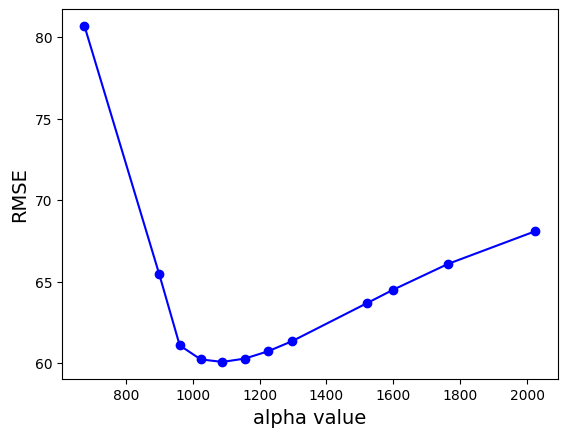

In [163]:
plt.plot(alpha_values, rmse_list2, '-bo')
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('alpha value', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

#### Re-running CV with optimal alpha

In [164]:
gaussian_process = GaussianProcessRegressor(kernel=k_best, alpha=alpha_opt)

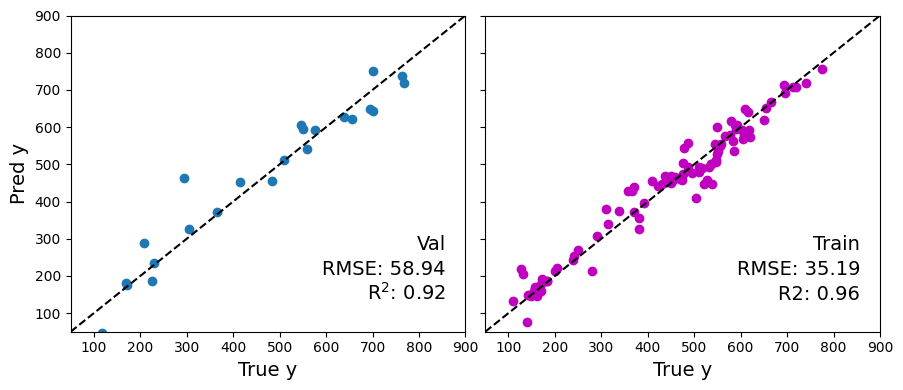

Kernel parameters: 325**2 * RBF(length_scale=0.241)
log marginal likelihood: -575.306
Root mean squared error: 58.94
Coefficient of determination: 0.92


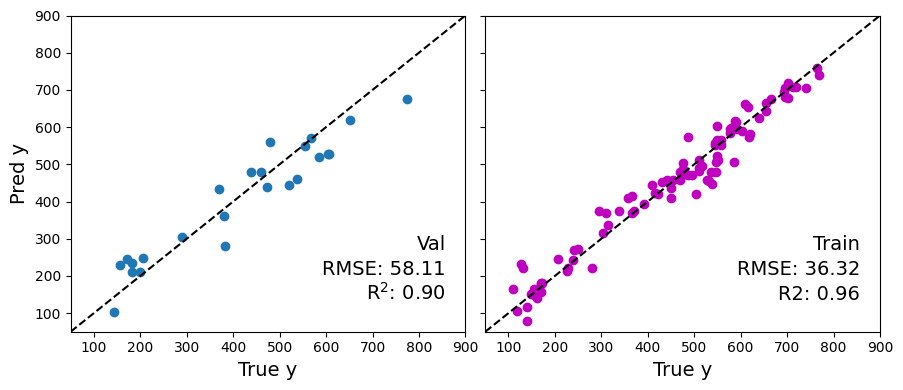

Kernel parameters: 330**2 * RBF(length_scale=0.266)
log marginal likelihood: -573.889
Root mean squared error: 58.11
Coefficient of determination: 0.90


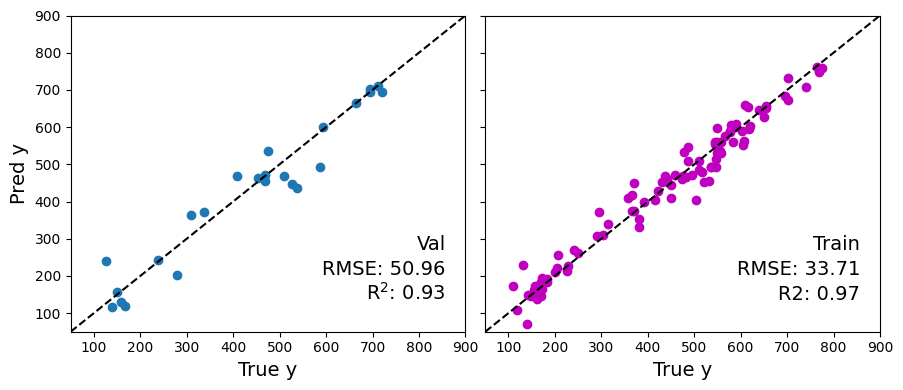

Kernel parameters: 329**2 * RBF(length_scale=0.252)
log marginal likelihood: -573.051
Root mean squared error: 50.96
Coefficient of determination: 0.93


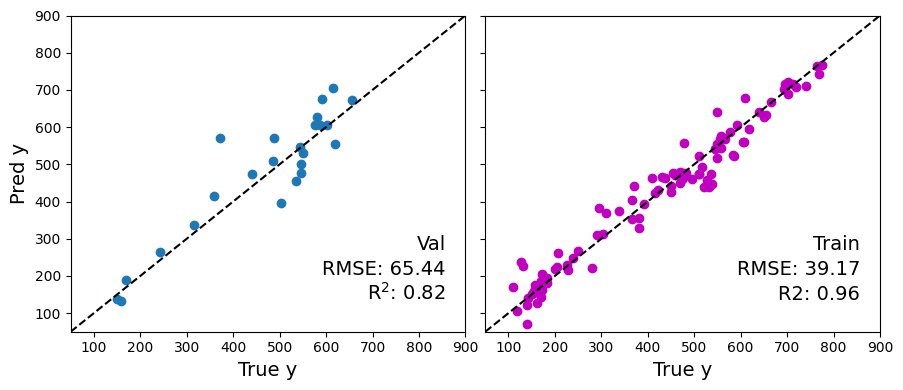

Kernel parameters: 345**2 * RBF(length_scale=0.304)
log marginal likelihood: -575.930
Root mean squared error: 65.44
Coefficient of determination: 0.82


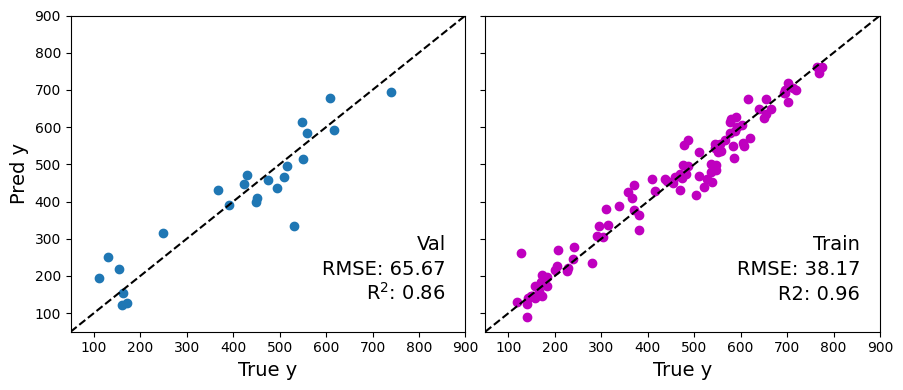

Kernel parameters: 334**2 * RBF(length_scale=0.314)
log marginal likelihood: -568.657
Root mean squared error: 65.67
Coefficient of determination: 0.86


In [165]:
kf = KFold(n_splits=5)

errors = []
kernels = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    mse_val = mean_squared_error(y_cv_val, y_pred_val)
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("log marginal likelihood: %.3f" %model.log_marginal_likelihood_value_)
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'mse_val': mse_val
            }

    errors.append(error)
    kernels.append(model.kernel_)

In [166]:
errors_gpr_cv_opt_alpha = pd.DataFrame(errors)
errors_gpr_cv_opt_alpha.mean()

kfold            3.000000
rmse_train      36.513219
r2_train         0.961530
rmse_val        59.825569
r2_val           0.886403
mse_val       3608.687281
dtype: float64

In [167]:
np.sqrt(errors_gpr_cv_opt_alpha['mse_val'].mean())

60.07235038446137

In [168]:
kernels

[325**2 * RBF(length_scale=0.241),
 330**2 * RBF(length_scale=0.266),
 329**2 * RBF(length_scale=0.252),
 345**2 * RBF(length_scale=0.304),
 334**2 * RBF(length_scale=0.314)]

In [169]:
# Again finding the best kernel parameters for final model training
sigma_cs = []
sigma_ls = []

print("Previous k_best: ", k_best)

for k in kernels:
    sigma_cs.append(k.k1.constant_value)
    sigma_ls.append(k.k2.length_scale)
k_opt = np.median(sigma_cs) * RBF(length_scale=np.median(sigma_ls), length_scale_bounds=(1e-4, 1e2))
k_opt.k1.constant_value_bounds = (10**-2, 10**7)

print("New k_best: ", k_opt)

Previous k_best:  327**2 * RBF(length_scale=0.223)
New k_best:  330**2 * RBF(length_scale=0.266)


### 4. Train the final GPR model

In [170]:
# IMP NOTE: The optimizer is set to None

gaussian_process = GaussianProcessRegressor(kernel=k_opt, alpha=alpha_opt, optimizer=None)

model = gaussian_process.fit(X,y)
print()
print(model.kernel_, model.kernel)


330**2 * RBF(length_scale=0.266) 330**2 * RBF(length_scale=0.266)


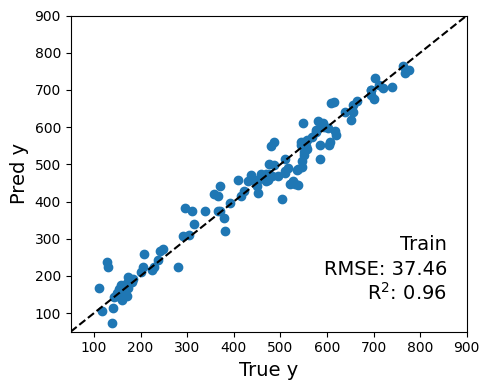

Kernel parameters: 330**2 * RBF(length_scale=0.266)
Root mean squared error: 37.46
Coefficient of determination: 0.96


In [171]:
y_pred = model.predict(X)

# Computing errors
rmse_train = np.sqrt(mean_squared_error(y, y_pred))
r2_train = r2_score(y, y_pred)

# Plot Parity plot
polt_parity(y,y_pred,label="Train")

print("Kernel parameters: %s"%(model.kernel_))
print("Root mean squared error: %.2f" % rmse_train)
print("Coefficient of determination: %.2f" % r2_train)


***

### 5. Uncertainty Prediction

In [172]:
y_pred, y_std = model.predict(X, return_std=True)

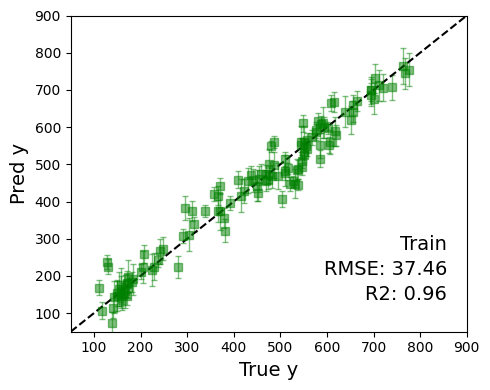

In [173]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

ax1.errorbar(y, y_pred, y_std*1.5, fmt='s', c='g', alpha=0.5, elinewidth=1, capsize=2)
ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('True y', fontsize=14)
ax1.set_ylabel('Pred y', fontsize=14)

ax1.text(0.95, 0.26, "Train", transform=ax1.transAxes, ha='right', fontsize=14)
ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

ax1.set_xlim([50,900])
ax1.set_ylim([50,900])

plt.tight_layout()
plt.show()

### Prediction for Test data

In [174]:
!gdown 1lrfEnHh9pPItZQNO6cms9gp5PmhIB5De

Downloading...
From: https://drive.google.com/uc?id=1lrfEnHh9pPItZQNO6cms9gp5PmhIB5De
To: /content/alloy-confp-test-data_v2.csv
100% 2.15k/2.15k [00:00<00:00, 8.28MB/s]


In [175]:
test_data = pd.read_csv('alloy-confp-test-data_v2.csv')
test_X = test_data[Xcols]
test_X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,0.000000,0.200000,0.200000,0.000000,0.200000,0.400000
1,0.076923,0.307692,0.000000,0.000000,0.307692,0.307692
2,0.000000,0.050000,0.237500,0.237500,0.237500,0.237500
3,0.000000,0.237500,0.050000,0.237500,0.237500,0.237500
4,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000
5,0.000000,0.149701,0.212575,0.212575,0.212575,0.212575
6,0.000000,0.212575,0.212575,0.212575,0.212575,0.149701
7,0.052632,0.210526,0.210526,0.000000,0.263158,0.263158
8,0.000000,0.225000,0.225000,0.225000,0.225000,0.100000
9,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667


In [176]:
test_y_pred, test_y_std = model.predict(test_X, return_std=True)

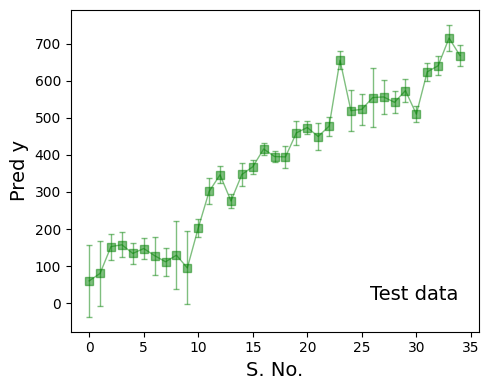

In [177]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))


ax1.errorbar(np.arange(len(test_y_pred)), test_y_pred, test_y_std*1.5, fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=1)
# ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Pred y', fontsize=14)

ax1.text(0.95, 0.1, "Test data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

#ax1.set_xlim([50,900])
#ax1.set_ylim([50,900])

plt.tight_layout()
plt.show()

### Question


3. Why error bars from some data points are smaller as compared to others?

The length of the error bar is ddetermined by the variable
``` test_y_std ```  which the standard deviation of the predictive distribution of the each data point.


If the target value has low variability around the mean then the length would be smaller in comparison with vice versa.

If the model has high confidence around the data then the standard deviation would be smaller

### Better models using Better Physical Features

### Question
4. Why inclusion of physical features of alloys is expected to improve the performance of the ML model?

* Often physical properties of the alloys are encode to predict the characteristic property of the material (Domain knowledge plays a cruical factor).By utilizing these features the model learns the underlying relationships between the target values and the features.It helps to generalize the model which prevents overfitting of the model.

In [178]:
!gdown 1eDfSMMDuOVSgsZPNwYJ1U5hIEHy-P4T6

Downloading...
From: https://drive.google.com/uc?id=1eDfSMMDuOVSgsZPNwYJ1U5hIEHy-P4T6
To: /content/alloy-full-train-data_v2.csv
100% 28.8k/28.8k [00:00<00:00, 67.5MB/s]


In [179]:
full_train_data = pd.read_csv('alloy-full-train-data_v2.csv')
full_train_data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,...,Dk_D.G,Dk_D.x,Dk_fH,Dk_fpi,Dk_fdash,Dk_fA,Dk_A,Dk_F,Dk_fineq,Dk_fsqrt
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,...,-2.421510,-1.090140,0.532049,-0.098240,5.981226,-2.030900,-2.584580,1.923412,1.884716,-2.762650
1,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.230839,0.005193,...,-0.106890,-0.011460,-0.194120,-0.220840,-0.225850,0.185239,0.337282,0.055958,0.288218,0.426169
2,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,...,0.115596,-0.317500,0.275243,-0.187710,-0.232830,0.286611,0.234105,-1.685660,0.107530,0.408426
3,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,...,1.109189,1.220168,-1.499770,-0.307840,-0.238250,0.880942,0.470273,-2.394630,-1.530350,0.369335
4,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,...,-0.258890,-0.411380,0.945172,0.392613,-0.210380,-0.576900,-0.229710,0.262366,0.509518,0.436561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,-1.227010,...,-0.497990,-1.295580,0.259228,-0.184950,-0.229030,0.030046,0.111643,-1.112220,0.630170,0.420612
116,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.014367,1.557345,...,-0.596120,-0.342130,-0.151650,-0.247360,-0.229560,0.072990,0.386799,1.435387,0.581871,0.439698
117,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.320476,-0.019970,...,0.120649,0.231689,-0.224640,-0.221560,-0.226910,0.309614,0.421990,0.012930,0.092413,0.423563
118,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.353340,1.187070,...,0.202019,0.491712,-0.811460,-0.267970,-0.230110,0.593701,0.707933,1.078177,-0.148420,0.426522


In [180]:
Xcols = full_train_data.columns[(full_train_data.columns.str.contains("C.")) | (full_train_data.columns.str.contains("Dk_"))]
Xcols

Index(['C.al', 'C.co', 'C.cr', 'C.cu', 'C.fe', 'C.ni', 'Dk_fr', 'Dk_G',
       'Dk_fG', 'Dk_fx', 'Dk_e.a', 'Dk_vec', 'Dk_Ec', 'Dk_w', 'Dk_fS',
       'Dk_D.r', 'Dk_D.G', 'Dk_D.x', 'Dk_fH', 'Dk_fpi', 'Dk_fdash', 'Dk_fA',
       'Dk_A', 'Dk_F', 'Dk_fineq', 'Dk_fsqrt'],
      dtype='object')

In [181]:
X = full_train_data[Xcols]
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,Dk_fG,Dk_fx,...,Dk_D.G,Dk_D.x,Dk_fH,Dk_fpi,Dk_fdash,Dk_fA,Dk_A,Dk_F,Dk_fineq,Dk_fsqrt
0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,-2.141950,-1.215900,...,-2.421510,-1.090140,0.532049,-0.098240,5.981226,-2.030900,-2.584580,1.923412,1.884716,-2.762650
1,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.230839,0.005193,-0.180080,-0.023960,...,-0.106890,-0.011460,-0.194120,-0.220840,-0.225850,0.185239,0.337282,0.055958,0.288218,0.426169
2,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,-0.083060,-0.051180,...,0.115596,-0.317500,0.275243,-0.187710,-0.232830,0.286611,0.234105,-1.685660,0.107530,0.408426
3,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,1.670192,1.446628,...,1.109189,1.220168,-1.499770,-0.307840,-0.238250,0.880942,0.470273,-2.394630,-1.530350,0.369335
4,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,-0.341910,-0.435350,...,-0.258890,-0.411380,0.945172,0.392613,-0.210380,-0.576900,-0.229710,0.262366,0.509518,0.436561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,-1.227010,-0.670300,-0.842130,...,-0.497990,-1.295580,0.259228,-0.184950,-0.229030,0.030046,0.111643,-1.112220,0.630170,0.420612
116,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.014367,1.557345,-0.705380,-0.519140,...,-0.596120,-0.342130,-0.151650,-0.247360,-0.229560,0.072990,0.386799,1.435387,0.581871,0.439698
117,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.320476,-0.019970,-0.000690,0.152051,...,0.120649,0.231689,-0.224640,-0.221560,-0.226910,0.309614,0.421990,0.012930,0.092413,0.423563
118,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.353340,1.187070,-0.050140,0.355758,...,0.202019,0.491712,-0.811460,-0.267970,-0.230110,0.593701,0.707933,1.078177,-0.148420,0.426522


In [182]:
y = full_train_data['HV']
y

0      139
1      295
2      545
3      701
4      207
      ... 
115    249
116    450
117    451
118    617
119    171
Name: HV, Length: 120, dtype: int64

In [183]:
#kernel = 300**2 * RBF(length_scale=0.2, length_scale_bounds=(1e-4, 1e2))
#kernel.k1.constant_value_bounds = (10**-2, 10**7)
noise_estimated = 35

gaussian_process = GaussianProcessRegressor(
    kernel=k_opt, alpha=noise_estimated**2, n_restarts_optimizer=3
)

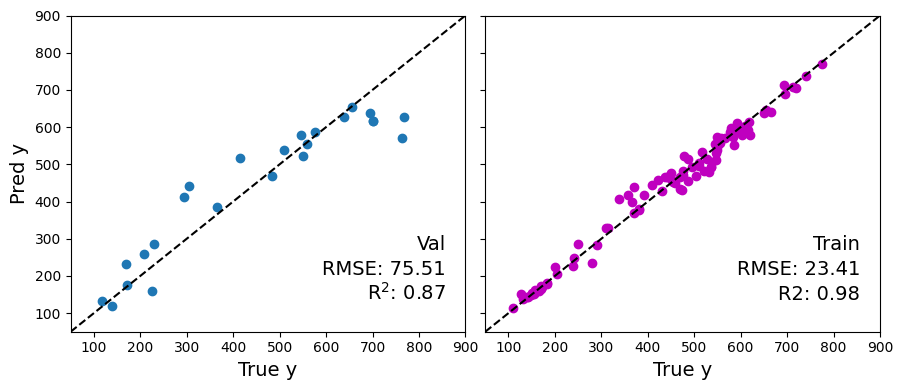

Kernel parameters: 303**2 * RBF(length_scale=2.85)
Root mean squared error: 75.51
Coefficient of determination: 0.87


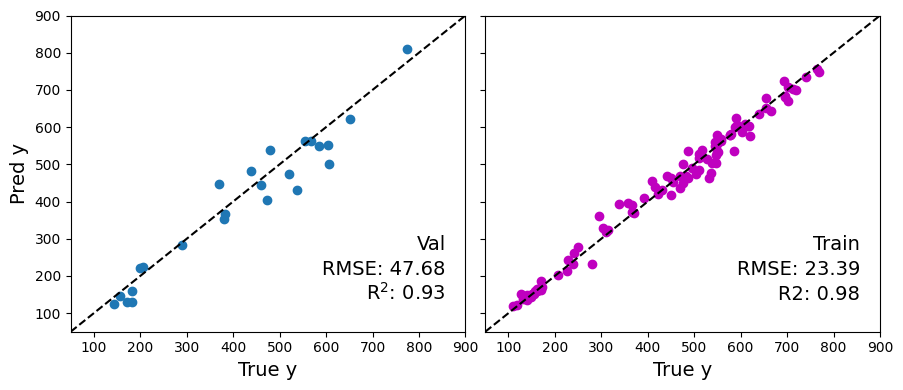

Kernel parameters: 304**2 * RBF(length_scale=2.85)
Root mean squared error: 47.68
Coefficient of determination: 0.93


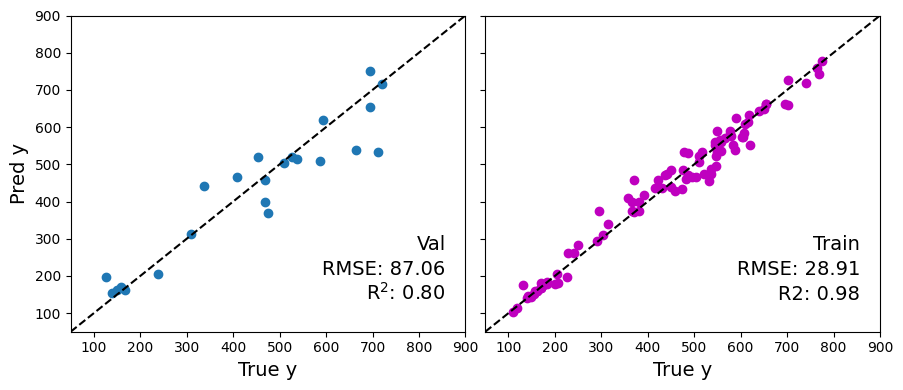

Kernel parameters: 294**2 * RBF(length_scale=3.55)
Root mean squared error: 87.06
Coefficient of determination: 0.80


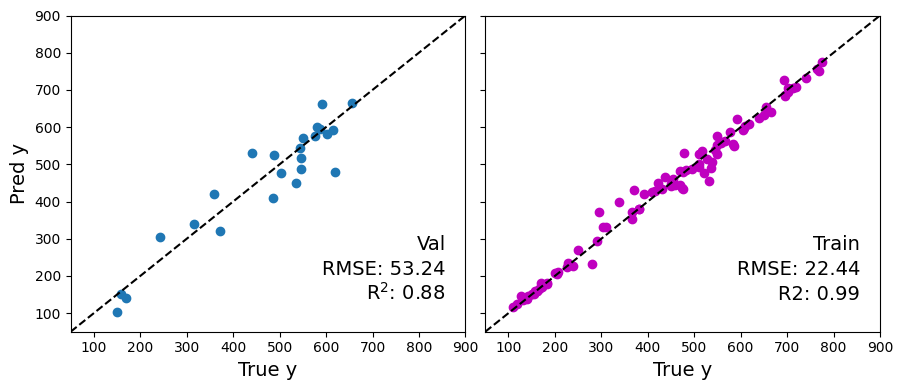

Kernel parameters: 291**2 * RBF(length_scale=2.82)
Root mean squared error: 53.24
Coefficient of determination: 0.88


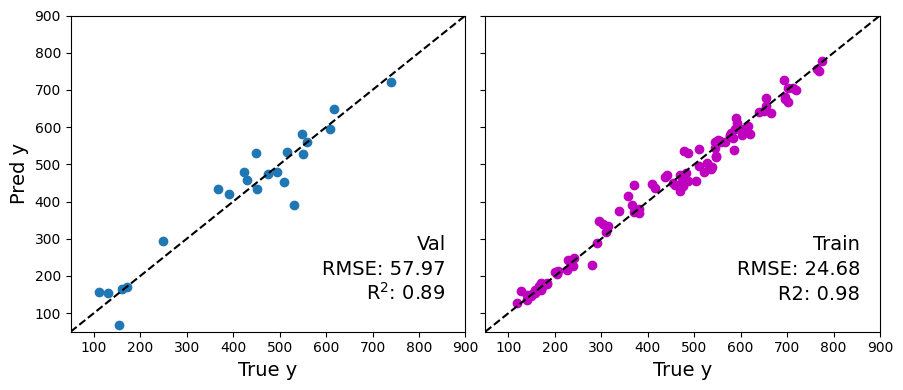

Kernel parameters: 298**2 * RBF(length_scale=2.86)
Root mean squared error: 57.97
Coefficient of determination: 0.89


In [184]:
kf = KFold(n_splits=5)

errors = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)

In [185]:
errors_gpr_cv_phFeatures = pd.DataFrame(errors)
errors_gpr_cv_phFeatures

,kfold,rmse_train,r2_train,rmse_val,r2_val
0,1,23.406577,0.982870,75.511026,0.874454
1,2,23.391226,0.984413,47.676755,0.930336
2,3,28.907049,0.975271,87.061441,0.802924
3,4,22.435694,0.986456,53.238292,0.879794
4,5,24.678294,0.982809,57.965926,0.891827


In [186]:
errors_gpr_cv_phFeatures[['rmse_val','r2_val']].mean()

rmse_val    64.290688
r2_val       0.875867
dtype: float64

### Question
5. Inclusion of physical features doesn't seem to improve the ML model performance. Are we missing something during the model training?

Yes, we have not done scaling on our features due to which the performance of the model is not improved. It also adds stability to the guassian process regression model

### Feature normalization; Retrain model

In [187]:
scaler = StandardScaler()

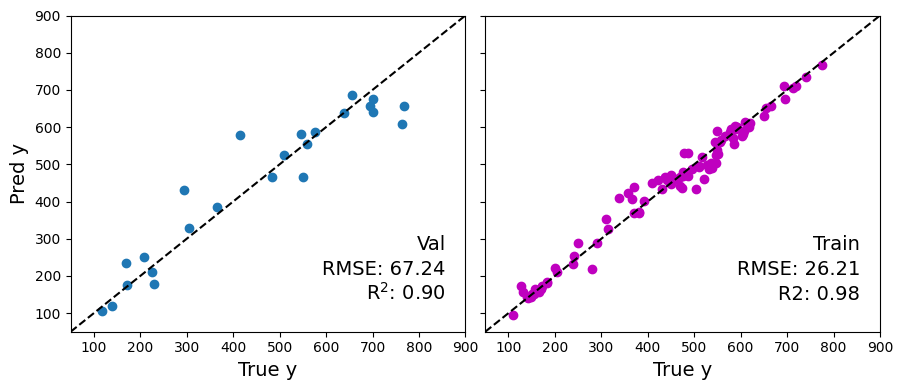

Kernel parameters: 268**2 * RBF(length_scale=4)
Root mean squared error: 67.24
Coefficient of determination: 0.90


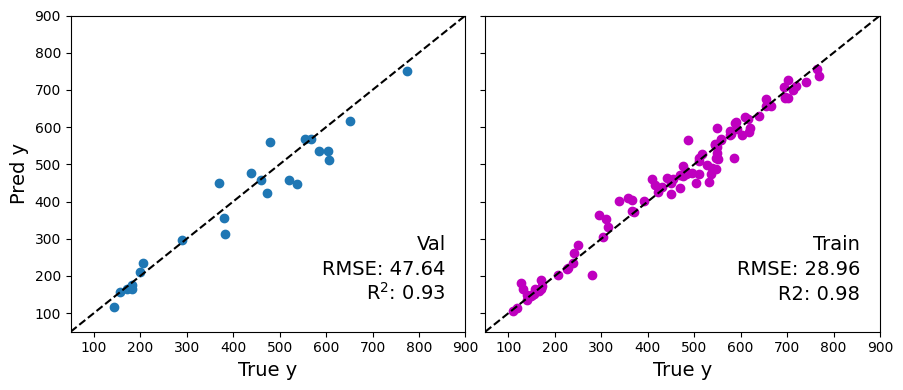

Kernel parameters: 269**2 * RBF(length_scale=4.26)
Root mean squared error: 47.64
Coefficient of determination: 0.93


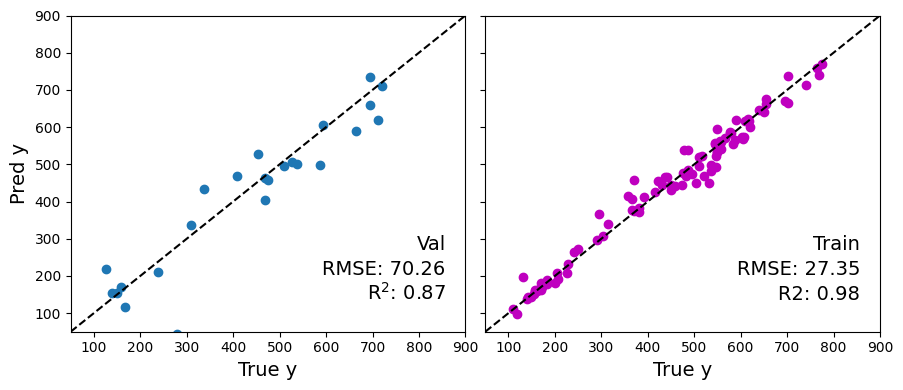

Kernel parameters: 269**2 * RBF(length_scale=4.61)
Root mean squared error: 70.26
Coefficient of determination: 0.87


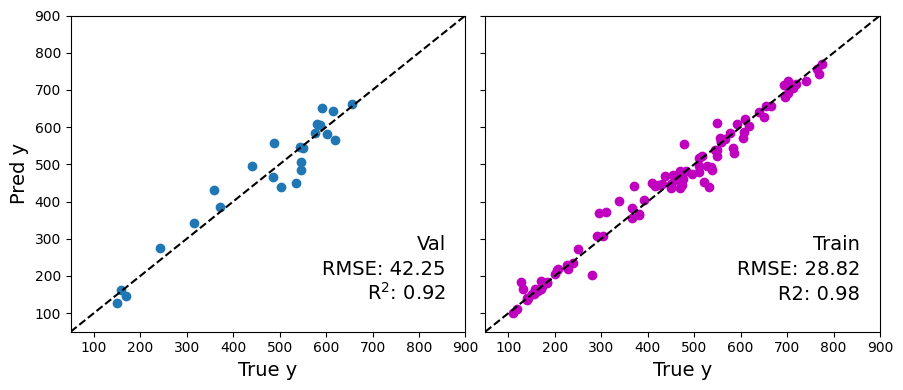

Kernel parameters: 273**2 * RBF(length_scale=4.32)
Root mean squared error: 42.25
Coefficient of determination: 0.92


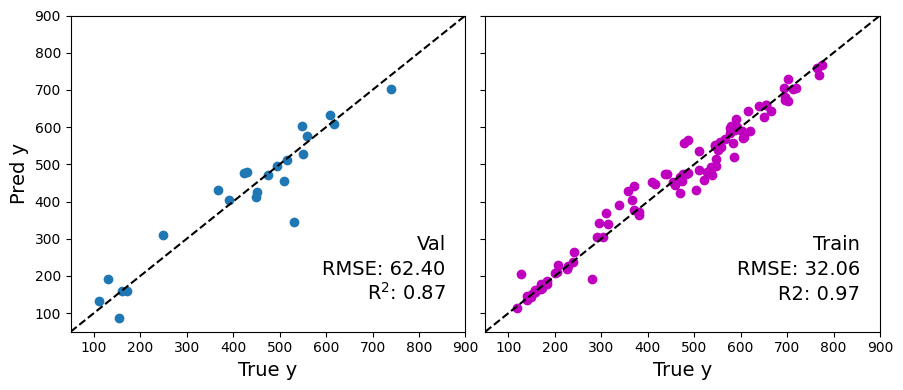

Kernel parameters: 285**2 * RBF(length_scale=4.95)
Root mean squared error: 62.40
Coefficient of determination: 0.87


In [188]:
kf = KFold(n_splits=5)

errors = []

for idx, (train, val) in enumerate(kf.split(X)):
    _X_cv_train = X.values[train]
    _X_cv_val = X.values[val]

    X_cv_train = scaler.fit_transform(_X_cv_train)
    X_cv_val = scaler.transform(_X_cv_val)

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]

    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)

In [189]:
errors_gpr_cv_fpnorm = pd.DataFrame(errors)
errors_gpr_cv_fpnorm

,kfold,rmse_train,r2_train,rmse_val,r2_val
0,1,26.209542,0.978522,67.240238,0.900450
1,2,28.962939,0.976104,47.639771,0.930444
2,3,27.353918,0.977857,70.261352,0.871644
3,4,28.818589,0.977654,42.252794,0.924284
4,5,32.057659,0.970990,62.395657,0.874663


In [190]:
errors_gpr_cv_fpnorm[['rmse_val','r2_val']].mean()

rmse_val    57.957962
r2_val       0.900297
dtype: float64

In [191]:
errors_gpr_cv['rmse_val'].mean(), errors_gpr_cv_opt_alpha['rmse_val'].mean(), errors_gpr_cv_fpnorm['rmse_val'].mean()

(64.57938953653502, 59.82556936370272, 57.9579623212035)

### Question
6. Again try optimization of the noise (alpha) parameter with normalized full set of features

In [192]:
alpha_values = np.array([26, 30, 31, 32, 33, 34, 35, 36, 39, 40, 42, 45])**2
hyper_params = {'alpha':alpha_values}

In [193]:
kernel = k_best.k1.constant_value * RBF(length_scale=k_best.k2.length_scale, length_scale_bounds=(1e-4, 1e2))
kernel.k1.constant_value_bounds = (10**-2, 10**7)

In [194]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)

In [195]:
scaler = StandardScaler()

scaler.fit(X)
X_scaled = scaler.transform(X)

In [198]:
clf2 = GridSearchCV(gaussian_process, hyper_params, cv=5,
                   scoring='neg_mean_squared_error', verbose=0)

In [199]:
clf2.fit(X_scaled,y)

GridSearchCV(cv=5,
             estimator=GaussianProcessRegressor(kernel=327**2 * RBF(length_scale=0.223),
                                                n_restarts_optimizer=3),
             param_grid={'alpha': array([ 676,  900,  961, 1024, 1089, 1156, 1225, 1296, 1521, 1600, 1764,
       2025])},
             scoring='neg_mean_squared_error')

In [200]:
rmse_list3 = np.sqrt(clf2.cv_results_['mean_test_score']*-1)
min_idx = np.argmin(rmse_list2)

In [201]:
alpha_opt = alpha_values[min_idx]

print()
print("Best CV error: %.4f" %rmse_list3[min_idx])
print("Optimal alpha: %.2f" %np.sqrt(alpha_opt))


Best CV error: 58.7539
Optimal alpha: 33.00


### NOTE: Things to be achieved simultaneously:
1. Optimization of alpha (hyper-parameters)
2. Normalization
3. Feature selection

### Feature selection for performance improvement

In [202]:
gaussian_process = GaussianProcessRegressor(
    kernel=k_opt, alpha=alpha_opt, n_restarts_optimizer=3
)

In [203]:
def run_cv(ml_model, X, y, n_cv = 5, normalize=False):
    """
    Function to run Cross-validation
    """
    kf = KFold(n_splits=n_cv)

    errors = []

    for idx, (train, val) in enumerate(kf.split(X)):

        if normalize:
            _X_cv_train = X.values[train]
            _X_cv_val = X.values[val]

            X_cv_train = scaler.fit_transform(_X_cv_train)
            X_cv_val = scaler.transform(_X_cv_val)

        else:
            X_cv_train = X.values[train]
            X_cv_val = X.values[val]

        y_cv_train = y.values[train]
        y_cv_val = y.values[val]

        # Model fit and prediction
        model = ml_model.fit(X_cv_train, y_cv_train)
        y_pred_val = model.predict(X_cv_val)

        # Computing errors
        rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))

        errors.append(rmse_val)
    return np.mean(np.array(errors))

In [204]:
# Greedy selection of features with minimum CV RMSE

current_Xcols = Xcols
rfe_results = {"rmse_cv":[], "sel_cols":[]}
for rfe_run_idx in range(15):

    _rmse_cvs = []
    for rm_idx, rm_col in enumerate(current_Xcols):
        _Xcols = current_Xcols.drop(rm_col)

        # Get CV error for this set
        _rmse_cv = run_cv(gaussian_process, X[_Xcols], y, normalize=True)
        _rmse_cvs.append(_rmse_cv)

    _rmse_cvs = np.array(_rmse_cvs)

    worst_col = current_Xcols[np.argmin(_rmse_cvs)]
    print("Worst column %s" %worst_col)
    print("RFE RMSE CV %.2f" %np.min(_rmse_cvs))
    current_Xcols = current_Xcols.drop(worst_col)
    rfe_results["rmse_cv"].append(np.min(_rmse_cvs))
    rfe_results["sel_cols"].append(current_Xcols)

Worst column Dk_D.x
RFE RMSE CV 57.54
Worst column Dk_fineq
RFE RMSE CV 56.55
Worst column C.co
RFE RMSE CV 55.72
Worst column Dk_w
RFE RMSE CV 54.91
Worst column Dk_fx
RFE RMSE CV 54.29
Worst column C.cr
RFE RMSE CV 53.46
Worst column Dk_fpi
RFE RMSE CV 52.48
Worst column Dk_fsqrt
RFE RMSE CV 52.16
Worst column Dk_A
RFE RMSE CV 51.83
Worst column Dk_fdash
RFE RMSE CV 51.51
Worst column Dk_fr
RFE RMSE CV 51.26
Worst column Dk_fG
RFE RMSE CV 51.18
Worst column Dk_G
RFE RMSE CV 51.00
Worst column Dk_D.r
RFE RMSE CV 51.34
Worst column Dk_Ec
RFE RMSE CV 51.86


#### Collect RFE results and plot them

In [205]:
n_features= len(Xcols) - np.arange(len(rfe_results["rmse_cv"])) - 1

In [206]:
min_idx = np.argmin(rfe_results["rmse_cv"])
rmse = rfe_results["rmse_cv"][min_idx]
sel_features = rfe_results["sel_cols"][min_idx]
sel_features

Index(['C.al', 'C.cu', 'C.fe', 'C.ni', 'Dk_e.a', 'Dk_vec', 'Dk_Ec', 'Dk_fS',
       'Dk_D.r', 'Dk_D.G', 'Dk_fH', 'Dk_fA', 'Dk_F'],
      dtype='object')

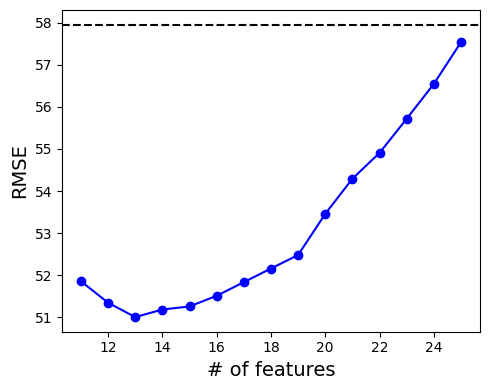

In [207]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(n_features, rfe_results["rmse_cv"], '-bo')
ax1.axhline(errors_gpr_cv_fpnorm['rmse_val'].mean(), linestyle='--', color='k')
#ax1.set_ylim(70,100)
ax1.set_xlabel('# of features', fontsize=14)
ax1.set_ylabel('RMSE', fontsize=14)
plt.tight_layout()

In [208]:
print("Initial number of features", len(Xcols))
print("Selected number of features", len(sel_features))

Initial number of features 26
Selected number of features 13


In [209]:
print("Mean square error with RFE (eV^2): ", rmse)

Mean square error with RFE (eV^2):  51.00186851606212


In [210]:
sel_features

Index(['C.al', 'C.cu', 'C.fe', 'C.ni', 'Dk_e.a', 'Dk_vec', 'Dk_Ec', 'Dk_fS',
       'Dk_D.r', 'Dk_D.G', 'Dk_fH', 'Dk_fA', 'Dk_F'],
      dtype='object')

### Below is the excerpt from the orginal article from which this data was taken

\![Screenshot%202024-04-03%20at%207.58.01%E2%80%AFAM.png](attachment:Screenshot%202024-04-03%20at%207.58.01%E2%80%AFAM.png)

***

### Question:


7. What are the limitation(s) of the manner in which we carried out the RFE step.

* In the greedy approach problem it removes a feature at a time depending on the error but that feature may be dependent upon the other feature so removing those feature may not lead to optimised model.
* We are using fixed number of iteration as 15 in the above case but there might be a case in which all the unnecessary features got already eliminated in previous steps or may not get eliminated basically it does not allow the model to choose the most optimal subset of features while training the model.
* The error metric in the above case we preferred RMSE but in few cases that may not be the best to choose.

8. Optimize alpha with the selected set of features to obtain hyper-parameters of the final GPR model.

In [211]:
sel_features = list(sel_features)

In [212]:
X_new=X[sel_features]

In [213]:
X_new

,C.al,C.cu,C.fe,C.ni,Dk_e.a,Dk_vec,Dk_Ec,Dk_fS,Dk_D.r,Dk_D.G,Dk_fH,Dk_fA,Dk_F
0,0.000000,0.000000,0.250000,0.250000,-0.647400,0.756149,2.135291,-1.220190,-2.054500,-2.421510,0.532049,-2.030900,1.923412
1,0.153846,0.076923,0.153846,0.153846,0.233661,0.122134,0.451604,1.171412,0.008795,-0.106890,-0.194120,0.185239,0.055958
2,0.222222,0.222222,0.222222,0.222222,0.625245,0.572989,-0.958400,0.210868,0.748469,0.115596,0.275243,0.286611,-1.685660
3,0.428571,0.071429,0.071429,0.142857,2.079699,-1.645860,-1.658190,-0.115100,1.598725,1.109189,-1.499770,0.880942,-2.394630
4,0.090909,0.181818,0.181818,0.181818,-0.763100,0.786121,0.084875,1.582192,-0.534760,-0.258890,0.945172,-0.576900,0.262366
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.166667,0.166667,0.166667,0.166667,0.625245,0.866045,0.009458,0.061126,0.229181,-0.497990,0.259228,0.030046,-1.112220
116,0.117647,0.000000,0.441176,0.147059,-0.273090,-0.737140,0.743195,-2.187470,-0.470630,-0.596120,-0.151650,0.072990,1.435387
117,0.166667,0.083333,0.166667,0.166667,0.201029,-0.013120,0.246484,1.438159,0.150677,0.120649,-0.224640,0.309614,0.012930
118,0.166667,0.000000,0.166667,0.166667,-0.223190,-0.892290,0.483511,0.061126,0.028839,0.202019,-0.811460,0.593701,1.078177


In [214]:
alpha_values = np.array([26, 30, 31, 32, 33, 34, 35, 36, 39, 40, 42, 45])**2
hyper_params = {'alpha':alpha_values}

In [215]:
kernel = k_best.k1.constant_value * RBF(length_scale=k_best.k2.length_scale, length_scale_bounds=(1e-4, 1e2))
kernel.k1.constant_value_bounds = (10**-2, 10**7)

In [216]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)

In [217]:
clf4 = GridSearchCV(gaussian_process, hyper_params, cv=5,
                   scoring='neg_mean_squared_error', verbose=0)

In [218]:
clf4.fit(X_new,y)

GridSearchCV(cv=5,
             estimator=GaussianProcessRegressor(kernel=327**2 * RBF(length_scale=0.223),
                                                n_restarts_optimizer=3),
             param_grid={'alpha': array([ 676,  900,  961, 1024, 1089, 1156, 1225, 1296, 1521, 1600, 1764,
       2025])},
             scoring='neg_mean_squared_error')

In [219]:
rmse_list4 = np.sqrt(clf4.cv_results_['mean_test_score']*-1)
min_idx = np.argmin(rmse_list4)

In [220]:
alpha_opt = alpha_values[min_idx]

print()
print("Best CV error: %.4f" %rmse_list4[min_idx])
print("Optimal alpha: %.2f" %np.sqrt(alpha_opt))


Best CV error: 66.0192
Optimal alpha: 45.00


In [221]:
gaussian_process = GaussianProcessRegressor(kernel=k_best, alpha=alpha_opt)

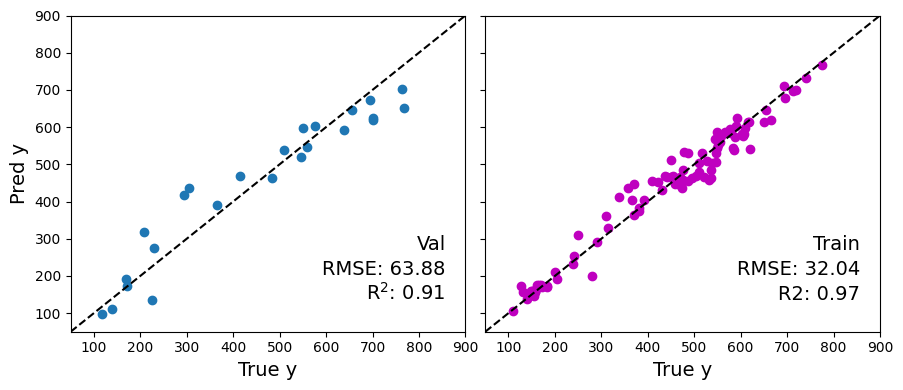

Kernel parameters: 303**2 * RBF(length_scale=2.32)
log marginal likelihood: -562.756
Root mean squared error: 63.88
Coefficient of determination: 0.91


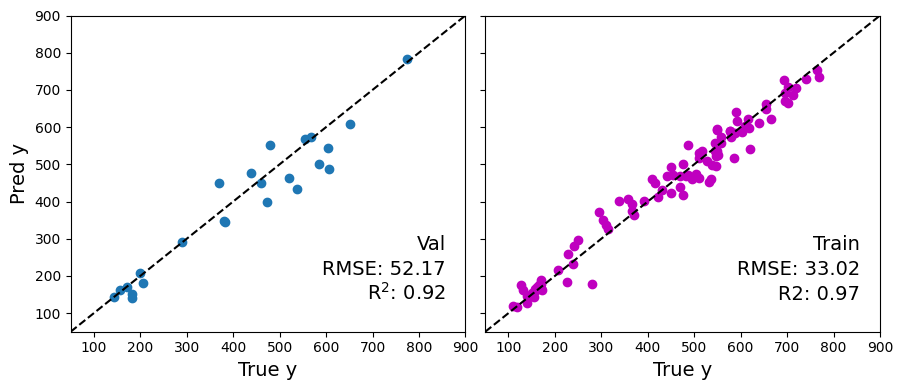

Kernel parameters: 318**2 * RBF(length_scale=2.41)
log marginal likelihood: -563.498
Root mean squared error: 52.17
Coefficient of determination: 0.92


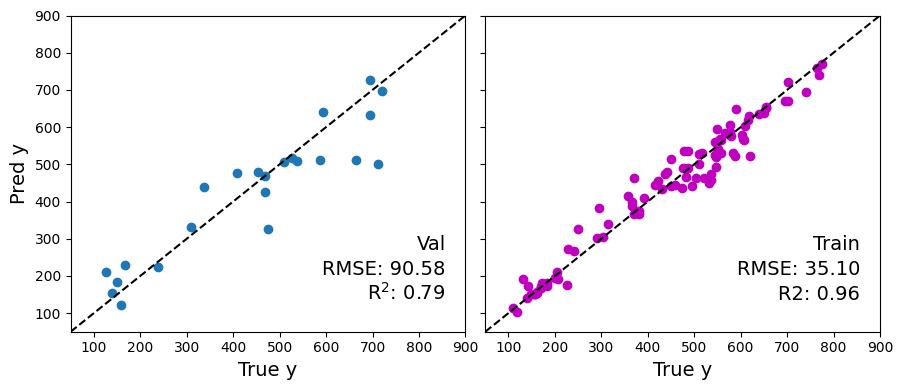

Kernel parameters: 304**2 * RBF(length_scale=2.9)
log marginal likelihood: -553.286
Root mean squared error: 90.58
Coefficient of determination: 0.79


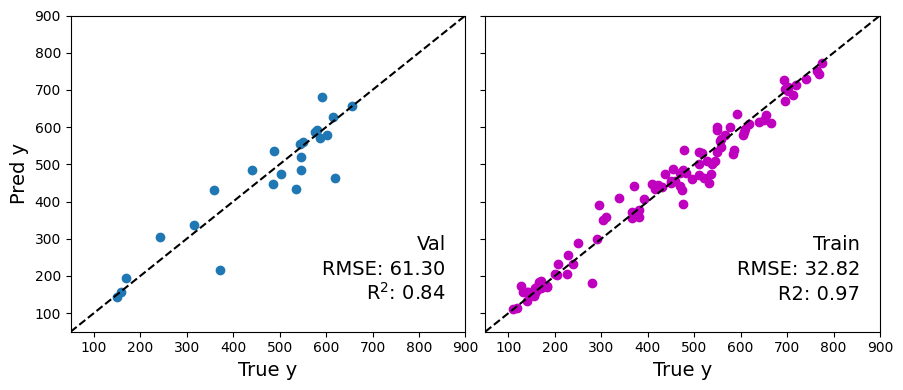

Kernel parameters: 303**2 * RBF(length_scale=2.41)
log marginal likelihood: -563.443
Root mean squared error: 61.30
Coefficient of determination: 0.84


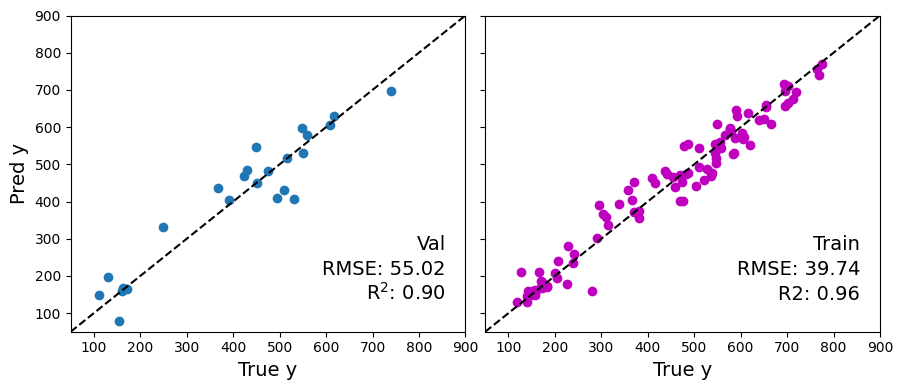

Kernel parameters: 326**2 * RBF(length_scale=2.83)
log marginal likelihood: -565.950
Root mean squared error: 55.02
Coefficient of determination: 0.90


In [222]:
kf = KFold(n_splits=5)

errors = []
kernels = []

for idx, (train, val) in enumerate(kf.split(X_new)):
    X_cv_train = X_new.values[train]
    X_cv_val = X_new.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    mse_val = mean_squared_error(y_cv_val, y_pred_val)
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("log marginal likelihood: %.3f" %model.log_marginal_likelihood_value_)
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'mse_val': mse_val
            }

    errors.append(error)
    kernels.append(model.kernel_)

In [223]:
errors_gpr_cv_opt_alpha = pd.DataFrame(errors)
errors_gpr_cv_opt_alpha.mean()

kfold            3.000000
rmse_train      34.542644
r2_train         0.965367
rmse_val        64.591172
r2_val           0.871312
mse_val       4358.536429
dtype: float64

In [224]:
np.sqrt(errors_gpr_cv_opt_alpha['mse_val'].mean())

66.01921257844207

In [225]:
kernels

[303**2 * RBF(length_scale=2.32),
 318**2 * RBF(length_scale=2.41),
 304**2 * RBF(length_scale=2.9),
 303**2 * RBF(length_scale=2.41),
 326**2 * RBF(length_scale=2.83)]

In [226]:
sigma_cs = []
sigma_ls = []

print("Previous k_best: ", k_best)

for k in kernels:
    sigma_cs.append(k.k1.constant_value)
    sigma_ls.append(k.k2.length_scale)
k_opt = np.median(sigma_cs) * RBF(length_scale=np.median(sigma_ls), length_scale_bounds=(1e-4, 1e2))
k_opt.k1.constant_value_bounds = (10**-2, 10**7)

print("New k_best: ", k_opt)

Previous k_best:  327**2 * RBF(length_scale=0.223)
New k_best:  304**2 * RBF(length_scale=2.41)


9. Use the obtained hyper-parameters (from the above question) to train the final GPR model and make predictions for the test data. Plot test predictions and associated uncertainty.  

In [227]:
### Downloading full test dataset file

In [228]:
!gdown 16duLg9Z1l_zHmF8egJHe3JfultJQgJvG

Downloading...
From: https://drive.google.com/uc?id=16duLg9Z1l_zHmF8egJHe3JfultJQgJvG
To: /content/alloy-full-test-data_v2.csv
100% 8.41k/8.41k [00:00<00:00, 21.5MB/s]


In [229]:
full_test_data = pd.read_csv('alloy-full-test-data_v2.csv')
full_test_data

,ID,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,Dk_fG,...,Dk_D.G,Dk_D.x,Dk_fH,Dk_fpi,Dk_fdash,Dk_fA,Dk_A,Dk_F,Dk_fineq,Dk_fsqrt
0,3,0.000000,0.200000,0.200000,0.000000,0.200000,0.400000,-2.459500,1.633789,-2.233840,...,-2.616330,-1.470860,0.515370,-0.118460,7.174715,-2.032790,-2.608270,1.694831,1.960380,-2.762640
1,6,0.076923,0.307692,0.000000,0.000000,0.307692,0.307692,-0.442620,0.130149,-2.109600,...,-2.352060,-2.731690,0.104131,-0.225300,-0.218230,-0.711780,-0.337940,0.318224,1.711901,0.446949
2,10,0.000000,0.050000,0.237500,0.237500,0.237500,0.237500,-1.991890,0.982325,-0.951940,...,-1.003070,-1.094090,2.030181,-0.126460,0.241019,-1.927230,-2.064900,0.994776,1.088997,-2.296930
3,13,0.000000,0.237500,0.050000,0.237500,0.237500,0.237500,-1.996240,-0.032940,-1.751410,...,-1.864720,-3.646720,2.063190,-0.145830,0.248059,-1.935920,-2.110360,0.133429,1.717838,-2.297010
4,15,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,-2.041210,0.875721,-1.188230,...,-1.302570,-1.546140,1.819967,-0.022170,0.366629,-1.944250,-2.124910,0.931010,1.307858,-2.296850
5,17,0.000000,0.149701,0.212575,0.212575,0.212575,0.212575,-2.024150,0.911468,-1.105510,...,-1.194830,-1.380320,1.886973,-0.058520,0.327945,-1.938510,-2.104200,0.952460,1.234290,-2.296880
6,23,0.000000,0.212575,0.212575,0.212575,0.212575,0.149701,-2.029250,0.902957,-1.101310,...,-1.191470,-1.443390,1.946416,-0.083390,0.338217,-1.940000,-2.110770,0.942649,1.232038,-2.296950
7,24,0.052632,0.210526,0.210526,0.000000,0.263158,0.263158,-0.789840,1.383000,-1.481570,...,-1.674470,-0.690120,0.046310,-0.198840,-0.195510,-1.015510,-0.577800,1.403938,1.398107,0.451784
8,26,0.000000,0.225000,0.225000,0.225000,0.225000,0.100000,-2.018310,0.929869,-1.018770,...,-1.088540,-1.363300,2.081721,-0.131710,0.306507,-1.936010,-2.097820,0.954114,1.156983,-2.297040
9,31,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,-2.089470,0.780963,-1.427490,...,-1.623840,-2.055240,1.659364,0.090686,0.464665,-1.959610,-2.183240,0.873817,1.503364,-2.296780


In [230]:
full_test_data = full_test_data.drop(['ID'],axis = 1)

In [232]:
full_test_data = full_test_data[:]

In [237]:
test_df = full_test_data[sel_features]

In [249]:
gaussian_process = GaussianProcessRegressor(kernel=k_opt, alpha=alpha_opt, optimizer=None)
model = gaussian_process.fit(X_new,y)

In [250]:
test_y_pred, test_y_std = model.predict(test_df, return_std=True)

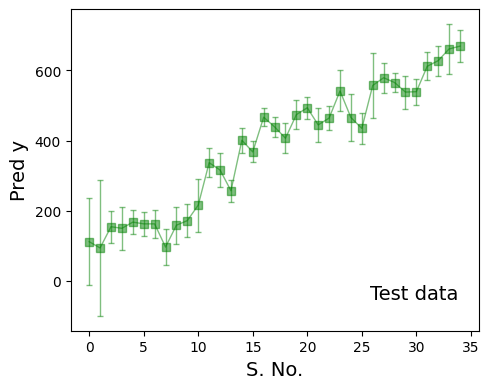

In [251]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))


ax1.errorbar(np.arange(len(test_y_pred)), test_y_pred, test_y_std*1.5, fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=1)
#ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Pred y', fontsize=14)

ax1.text(0.95, 0.1, "Test data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

#ax1.set_xlim([50,900])
#ax1.set_ylim([50,900])

plt.tight_layout()
plt.show()